In [2]:
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import lib

In [4]:
tree_struct_list = (2, 3, 60)
tree_diff_ratio = (0.5, 0.2, 0.05)
# tree_struct_list = (1, 60, )
# tree_diff_ratio = (0.5, 0.05, )
n_input_neurons = 500
key = jax.random.PRNGKey(23)
patterns_tree = lib.UltraMetricTree(key, n_input_neurons, tree_struct_list, tree_diff_ratio)
patterns_tree.construct_tree()
tree_network = lib.TreeNetwork(n_input_neurons, tree_struct_list=tree_struct_list[:-1], tree_decay1_list=(0.99, 0.99), tree_decay2_list=(0.99, 0.99), decay3=0.99)
all_descendents = jnp.array(patterns_tree.descendents)[0]

In [10]:
tree_network

depth of the current layer: 0, number of gate units: 2.
Each gate unit in this layer controls a tree of gate layers that has tree struct (3,).

In [9]:
tree_network.sub_trees

[depth of the current layer: 1, number of gate units: 3.
 This is the last classification layer, the next layer consists of 3 hopfield networks,
 depth of the current layer: 1, number of gate units: 3.
 This is the last classification layer, the next layer consists of 3 hopfield networks]

In [11]:
all_descendents.shape

(2, 3, 60, 500)

In [12]:
"""weights initialization"""
tree_network.initialize(all_descendents, n_iterations=1)

In [15]:
"""online training"""
all_descendents_flattened = np.array(all_descendents.reshape((-1, n_input_neurons)))
n_descendents = all_descendents_flattened.shape[0]
n_epochs = 12000
np.random.seed(0)

test_spacing = 50
tolerance = 0.01*n_input_neurons
n_failures_list = np.zeros(int(n_epochs/test_spacing))
error1_list = np.zeros(int(n_epochs/test_spacing))
error2_list = np.zeros((int(n_epochs/test_spacing), tree_struct_list[0]))

pbar = tqdm(range(n_epochs))
idx_list=0
for i in pbar:
    sample_idx = np.random.randint(n_descendents)
    tree_network.update_weights(all_descendents_flattened[sample_idx])

    # comment out this block if don't want to record tests during training
    if i%test_spacing == 0:
        n_failures=0
        for j in range(n_descendents):
            x = all_descendents_flattened[j]
            y = tree_network.retrieve(x, countingQ=True, n_hopfield_iterations=10)
            if np.sum(np.abs(x-y)) > tolerance:
                n_failures += 1

        error1 = tree_network.get_misclassification_percentage()
        error2 = np.array([tree_network.sub_trees[k].get_misclassification_percentage() for k in range(tree_network.n_gate_units)])
        tree_network.reset_counting_record()
        
        n_failures_list[idx_list] = n_failures
        error1_list[idx_list] = error1
        error2_list[idx_list] = error2
        idx_list += 1


  0%|          | 0/12000 [00:00<?, ?it/s]/home/caifangxu/.pyenv/versions/3.10.1/envs/rotation/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 12000/12000 [05:22<00:00, 37.26it/s]


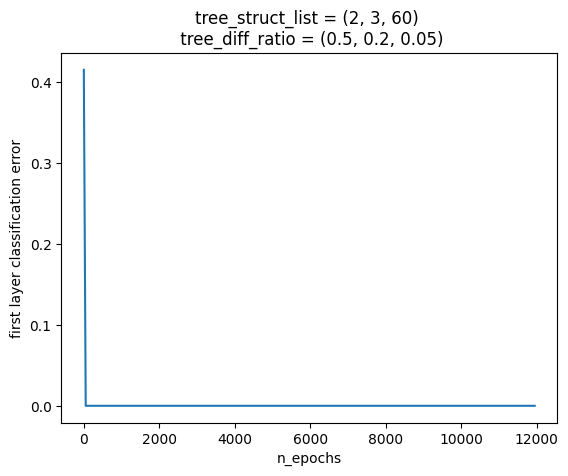

In [16]:
plt.plot(np.arange(0, n_epochs, test_spacing), error1_list[0:]);
plt.xlabel("n_epochs")
plt.ylabel("first layer classification error")
plt.title("tree_struct_list = (2, 3, 60) \n tree_diff_ratio = (0.5, 0.2, 0.05)");

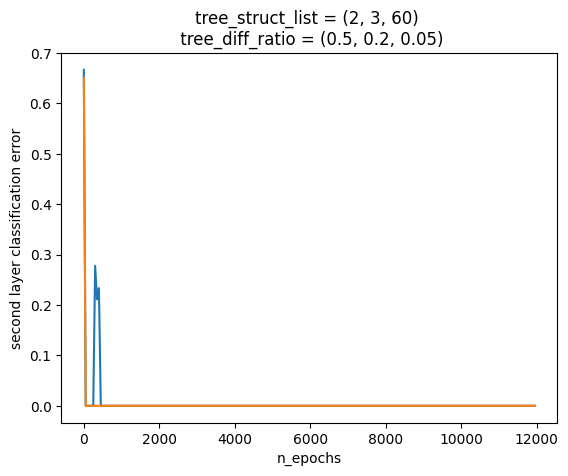

In [17]:
plt.plot(np.arange(0, n_epochs, test_spacing), error2_list);
plt.xlabel("n_epochs")
plt.ylabel("second layer classification error")
plt.title("tree_struct_list = (2, 3, 60) \n tree_diff_ratio = (0.5, 0.2, 0.05)");

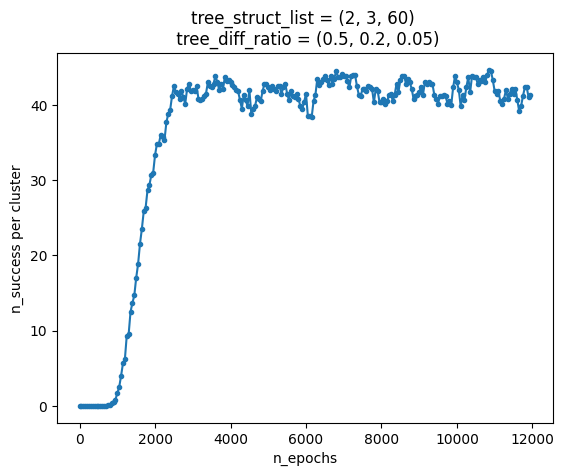

In [29]:
plt.plot(np.arange(0, n_epochs, test_spacing), (n_descendents - n_failures_list)/tree_struct_list[0]/tree_struct_list[1], marker=".")
plt.xlabel("n_epochs")
plt.ylabel("n_success per cluster")
plt.title("tree_struct_list = (2, 3, 60) \n tree_diff_ratio = (0.5, 0.2, 0.05)");

In [27]:
tolerance = 0.01*n_input_neurons
n_failures = 0
for j in range(n_descendents):
    x = all_descendents_flattened[j]
    y = tree_network.retrieve(x, n_hopfield_iterations=10)
    if np.sum(np.abs(x-y)) > tolerance:
        n_failures += 1
print(n_failures/n_descendents)

0.28055555555555556
